# Rule Set 3

> Python package to predict the activity of CRISPR sgRNA sequences using Rule Set 3

## Install

`pip install git+ssh://git@github.com/gpp-rnd/rs3.git`

## Quick Start

### Sequence based model

To calculate Rule Set 3 (sequence) scores, import
the `predict_seq` function from the `seq` module.

In [ ]:
from rs3.seq import predict_seq

You can store the 30mer context sequences you want to predict as a list.

In [ ]:
context_seqs = ['GACGAAAGCGACAACGCGTTCATCCGGGCA', 'AGAAAACACTAGCATCCCCACCCGCGGACT']

You can specify either
[Hsu2013](https://www.nature.com/articles/nbt.2647) or
[Chen2013](https://www.sciencedirect.com/science/article/pii/S0092867413015316?via%3Dihub)
as the tracrRNA to score with. We generally find any tracrRNA that does not have a T
in the fifth position is better predicted with the Chen2013 input.

In [ ]:
predict_seq(context_seqs, sequence_tracr='Hsu2013')

Calculating sequence-based features


100%|██████████| 2/2 [00:00<00:00, 244.20it/s]


array([-0.86673522,  1.09560723])

### Target based model

To get target scores, which use features at the endogenous target site to make predictions,
you must build or load feature matrices for the amino acid sequences, conservation scores, and protein domains.

As an example, we'll calculate target scores for 250 sgRNAs in the GeckoV2 library.

In [ ]:
import pandas as pd
from rs3.predicttarg import predict_target
from rs3.targetfeat import (add_target_columns,
                            get_aa_subseq_df,
                            get_protein_domain_features,
                            get_conservation_features)

In [ ]:
design_df = pd.read_table('test_data/sgrna-designs.txt')
design_df.head()

,Input,Quota,Target Taxon,Target Gene ID,Target Gene Symbol,Target Transcript,Target Reference Coords,Target Alias,CRISPR Mechanism,Target Domain,...,On-Target Rank Weight,Off-Target Rank Weight,Combined Rank,Preselected As,Matching Active Arrayed Oligos,Matching Arrayed Constructs,Pools Containing Matching Construct,Pick Order,Picking Round,Picking Notes
0,PSMB7,2,9606,ENSG00000136930,PSMB7,ENST00000259457.8,NaN,NaN,CRISPRko,CDS,...,1.0,1.0,7,GCAGATACAAGAGCAACTGA,NaN,BRDN0004619103,NaN,1,0,Preselected
1,PSMB7,2,9606,ENSG00000136930,PSMB7,ENST00000259457.8,NaN,NaN,CRISPRko,CDS,...,1.0,1.0,48,AAAACTGGCACGACCATCGC,NaN,NaN,NaN,2,0,Preselected
2,PRC1,2,9606,ENSG00000198901,PRC1,ENST00000394249.8,NaN,NaN,CRISPRko,CDS,...,1.0,1.0,7,AAAAGATTTGCGCACCCAAG,NaN,NaN,NaN,1,0,Preselected
3,PRC1,2,9606,ENSG00000198901,PRC1,ENST00000394249.8,NaN,NaN,CRISPRko,CDS,...,1.0,1.0,8,CTTTGACCCAGACATAATGG,NaN,NaN,NaN,2,0,Preselected
4,TOP1,2,9606,ENSG00000198900,TOP1,ENST00000361337.3,NaN,NaN,CRISPRko,CDS,...,1.0,1.0,1,NaN,NaN,BRDN0001486452,NaN,2,1,NaN


Throughout the analysis we will be using a core set of ID columns to merge the
feature matrices. These ID columns should uniquely identify an sgRNA and its target site.

In [ ]:
id_cols = ['sgRNA Context Sequence', 'Target Cut Length', 'Target Transcript', 'Orientation']

#### Amino acid sequence input

To calculate the amino acid sequence matrix, you must first load the complete
sequence from ensembl using the `build_transcript_aa_seq_df.` See the documentation
for the `predicttarget` module for an example of how to use this function.

In this example we will use amino acid sequences that have been
precalculated using the `write_transcript_data` function in the
`targetdata` module. Check out the documentation for this module for
more information on how to use this function.

We use pyarrow to read the written transcript data. The stored transcripts are
indexed by their Ensembl ID without the version number identifier.
To get this shortened version of the Ensembl ID use the `add_target_columns` function
from the `targetfeat` module. This function adds the 'Transcript Base' column as well
as a column indicating the amino acid index ('AA Index') of the cut site. The 'AA Index'
column will be used for merging with the amino acid translations.

In [ ]:
design_targ_df = add_target_columns(design_df)
design_targ_df.head()

,Input,Quota,Target Taxon,Target Gene ID,Target Gene Symbol,Target Transcript,Target Reference Coords,Target Alias,CRISPR Mechanism,Target Domain,...,Combined Rank,Preselected As,Matching Active Arrayed Oligos,Matching Arrayed Constructs,Pools Containing Matching Construct,Pick Order,Picking Round,Picking Notes,AA Index,Transcript Base
0,PSMB7,2,9606,ENSG00000136930,PSMB7,ENST00000259457.8,NaN,NaN,CRISPRko,CDS,...,7,GCAGATACAAGAGCAACTGA,NaN,BRDN0004619103,NaN,1,0,Preselected,64,ENST00000259457
1,PSMB7,2,9606,ENSG00000136930,PSMB7,ENST00000259457.8,NaN,NaN,CRISPRko,CDS,...,48,AAAACTGGCACGACCATCGC,NaN,NaN,NaN,2,0,Preselected,46,ENST00000259457
2,PRC1,2,9606,ENSG00000198901,PRC1,ENST00000394249.8,NaN,NaN,CRISPRko,CDS,...,7,AAAAGATTTGCGCACCCAAG,NaN,NaN,NaN,1,0,Preselected,106,ENST00000394249
3,PRC1,2,9606,ENSG00000198901,PRC1,ENST00000394249.8,NaN,NaN,CRISPRko,CDS,...,8,CTTTGACCCAGACATAATGG,NaN,NaN,NaN,2,0,Preselected,263,ENST00000394249
4,TOP1,2,9606,ENSG00000198900,TOP1,ENST00000361337.3,NaN,NaN,CRISPRko,CDS,...,1,NaN,NaN,BRDN0001486452,NaN,2,1,NaN,140,ENST00000361337


In [ ]:
transcript_bases = design_targ_df['Transcript Base'].unique()
transcript_bases[0:5]

array(['ENST00000259457', 'ENST00000394249', 'ENST00000361337',
       'ENST00000368328', 'ENST00000610426'], dtype=object)

In [ ]:
aa_seq_df = pd.read_parquet('test_data/target_data/aa_seqs.pq', engine='pyarrow',
                            filters=[[('Transcript Base', 'in', transcript_bases)]])
aa_seq_df.head()

,Target Transcript,Target Total Length,Transcript Base,version,seq,molecule,desc,id,AA len
0,ENST00000259457.8,834,ENST00000259457,3,MAAVSVYAPPVGGFSFDNCRRNAVLEADFAKRGYKLPKVRKTGTTI...,protein,None,ENSP00000259457,277
1,ENST00000394249.8,1863,ENST00000394249,3,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...,protein,None,ENSP00000377793,620
2,ENST00000361337.3,2298,ENST00000361337,2,MSGDHLHNDSQIEADFRLNDSHKHKDKHKDREHRHKEHKKEKDREK...,protein,None,ENSP00000354522,765
3,ENST00000368328.5,267,ENST00000368328,4,MALSTIVSQRKQIKRKAPRGFLKRVFKRKKPQLRLEKSGDLLVHLN...,protein,None,ENSP00000357311,88
4,ENST00000610426.5,783,ENST00000610426,1,MPQNEYIELHRKRYGYRLDYHEKKRKKESREAHERSKKAKKMIGLK...,protein,None,ENSP00000483484,260


From the complete transcript translations, we extract an amino acid subsequence as input to our model.
The subsequence is centered around the amino acid encoded by the
nucleotide preceding the cut site in the direction of transcription.
This is the nucleotide that corresponds to the 'Target Cut Length'
in a CRISPick design file. We take 16 amino acids on either side of the cut site for a
total sequence length of 33.

The `get_aa_subseq_df` from the `targetfeat` module
will calculate these subsequences from the complete amino acid sequences.

In [ ]:
aa_subseq_df = get_aa_subseq_df(sg_designs=design_targ_df, aa_seq_df=aa_seq_df, width=16,
                                id_cols=id_cols)
aa_subseq_df.head()

,Target Transcript,Target Total Length,Transcript Base,version,seq,molecule,desc,id,AA len,Target Cut Length,sgRNA Context Sequence,Orientation,AA Index,extended_seq,AA 0-Indexed,AA 0-Indexed padded,seq_start,seq_end,AA Subsequence
0,ENST00000259457.8,834,ENST00000259457,3,MAAVSVYAPPVGGFSFDNCRRNAVLEADFAKRGYKLPKVRKTGTTI...,protein,None,ENSP00000259457,277,191,TGGAGCAGATACAAGAGCAACTGAAGGGAT,sense,64,-----------------MAAVSVYAPPVGGFSFDNCRRNAVLEADF...,63,80,64,96,GVVYKDGIVLGADTRATEGMVVADKNCSKIHFI
1,ENST00000259457.8,834,ENST00000259457,3,MAAVSVYAPPVGGFSFDNCRRNAVLEADFAKRGYKLPKVRKTGTTI...,protein,None,ENSP00000259457,277,137,CCGGAAAACTGGCACGACCATCGCTGGGGT,sense,46,-----------------MAAVSVYAPPVGGFSFDNCRRNAVLEADF...,45,62,46,78,AKRGYKLPKVRKTGTTIAGVVYKDGIVLGADTR
2,ENST00000394249.8,1863,ENST00000394249,3,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...,protein,None,ENSP00000377793,620,316,TAGAAAAAGATTTGCGCACCCAAGTGGAAT,sense,106,-----------------MRRSEVLAEESIVCLQKALNHLREIWELI...,105,122,106,138,EEGETTILQLEKDLRTQVELMRKQKKERKQELK
3,ENST00000394249.8,1863,ENST00000394249,3,MRRSEVLAEESIVCLQKALNHLREIWELIGIPEDQRLQRTEVVKKH...,protein,None,ENSP00000377793,620,787,TGGCCTTTGACCCAGACATAATGGTGGCCA,antisense,263,-----------------MRRSEVLAEESIVCLQKALNHLREIWELI...,262,279,263,295,WDRLQIPEEEREAVATIMSGSKAKVRKALQLEV
4,ENST00000361337.3,2298,ENST00000361337,2,MSGDHLHNDSQIEADFRLNDSHKHKDKHKDREHRHKEHKKEKDREK...,protein,None,ENSP00000354522,765,420,AAATACTCACTCATCCTCATCTCGAGGTCT,antisense,140,-----------------MSGDHLHNDSQIEADFRLNDSHKHKDKHK...,139,156,140,172,GYFVPPKEDIKPLKRPRDEDDADYKPKKIKTED


The amino acid subsequence input should have a column 'AA Subsequence' as well
as the `id_cols`. If an sgRNA cannot be associated with a translated sequence then it is okay to exclude it
from this input.

#### Lite Scores

You now have
all the information you need to calculate "lite" Target Scores, which are less data intensive,
with the `predict_target` function from the
`predicttarg` module.

In [ ]:
lite_predictions = predict_target(design_df=design_df,
                                  aa_subseq_df=aa_subseq_df)
design_df['Target Score Lite'] = lite_predictions
design_df.head()

/Users/pdeweird/opt/anaconda3/envs/rs3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.0.dev0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/pdeweird/opt/anaconda3/envs/rs3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.dev0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


,Input,Quota,Target Taxon,Target Gene ID,Target Gene Symbol,Target Transcript,Target Reference Coords,Target Alias,CRISPR Mechanism,Target Domain,...,Off-Target Rank Weight,Combined Rank,Preselected As,Matching Active Arrayed Oligos,Matching Arrayed Constructs,Pools Containing Matching Construct,Pick Order,Picking Round,Picking Notes,Target Score Lite
0,PSMB7,2,9606,ENSG00000136930,PSMB7,ENST00000259457.8,NaN,NaN,CRISPRko,CDS,...,1.0,7,GCAGATACAAGAGCAACTGA,NaN,BRDN0004619103,NaN,1,0,Preselected,0.012467
1,PSMB7,2,9606,ENSG00000136930,PSMB7,ENST00000259457.8,NaN,NaN,CRISPRko,CDS,...,1.0,48,AAAACTGGCACGACCATCGC,NaN,NaN,NaN,2,0,Preselected,0.048338
2,PRC1,2,9606,ENSG00000198901,PRC1,ENST00000394249.8,NaN,NaN,CRISPRko,CDS,...,1.0,7,AAAAGATTTGCGCACCCAAG,NaN,NaN,NaN,1,0,Preselected,-0.129234
3,PRC1,2,9606,ENSG00000198901,PRC1,ENST00000394249.8,NaN,NaN,CRISPRko,CDS,...,1.0,8,CTTTGACCCAGACATAATGG,NaN,NaN,NaN,2,0,Preselected,0.061647
4,TOP1,2,9606,ENSG00000198900,TOP1,ENST00000361337.3,NaN,NaN,CRISPRko,CDS,...,1.0,1,NaN,NaN,BRDN0001486452,NaN,2,1,NaN,-0.009100


If you would like to calculate full target scores then follow the sections below.

#### Protein domain input

To calculate full target scores you will also need inputs for protein domains
and conservation.

The protein domain input should have 16 binary columns for 16 different
protein domain sources in addition to the `id_cols`. The protein
domain sources are 'Pfam', 'PANTHER', 'HAMAP', 'SuperFamily', 'TIGRfam', 'ncoils', 'Gene3D',
'Prosite_patterns', 'Seg', 'SignalP', 'TMHMM', 'MobiDBLite',
'PIRSF', 'PRINTS', 'Smart', 'Prosite_profiles'. These columns should be kept in order
when inputting for scoring.

In this example we will load the protein domain information from a parquet file, which
was written using `write_transcript_data` function in the `targetdata` module.
You can also query transcript data on the fly, by using the `build_translation_overlap_df`
function. See the documentation for the `predicttarg` module for more information on how to do this.

In [ ]:
domain_df = pd.read_parquet('test_data/target_data/protein_domains.pq', engine='pyarrow',
                            filters=[[('Transcript Base', 'in', transcript_bases)]])
domain_df.head()

,type,cigar_string,id,hit_end,feature_type,description,seq_region_name,end,hit_start,translation_id,interpro,hseqname,Transcript Base,align_type,start
0,Pfam,,PF12465,36,protein_feature,"Proteasome beta subunit, C-terminal",ENSP00000259457,271,1,976188,IPR024689,PF12465,ENST00000259457,None,235
1,Pfam,,PF00227,190,protein_feature,"Proteasome, subunit alpha/beta",ENSP00000259457,221,2,976188,IPR001353,PF00227,ENST00000259457,None,41
2,PRINTS,,PR00141,0,protein_feature,"Peptidase T1A, proteasome beta-subunit",ENSP00000259457,66,0,976188,IPR000243,PR00141,ENST00000259457,None,51
3,PRINTS,,PR00141,0,protein_feature,"Peptidase T1A, proteasome beta-subunit",ENSP00000259457,182,0,976188,IPR000243,PR00141,ENST00000259457,None,171
4,PRINTS,,PR00141,0,protein_feature,"Peptidase T1A, proteasome beta-subunit",ENSP00000259457,193,0,976188,IPR000243,PR00141,ENST00000259457,None,182


Now to transform the `domain_df` into a wide form for model input, we use the `get_protein_domain_features`
function from the `targetfeat` module.

In [ ]:
domain_feature_df = get_protein_domain_features(design_targ_df, domain_df, id_cols=id_cols)
domain_feature_df.head()

,sgRNA Context Sequence,Target Cut Length,Target Transcript,Orientation,Pfam,PANTHER,HAMAP,SuperFamily,TIGRfam,ncoils,Gene3D,Prosite_patterns,Seg,SignalP,TMHMM,MobiDBLite,PIRSF,PRINTS,Smart,Prosite_profiles
0,AAAAGAATGATGAAAAGACACCACAGGGAG,244,ENST00000610426.5,sense,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,AAAAGAGCCATGAATCTAAACATCAGGAAT,640,ENST00000223073.6,sense,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0
2,AAAAGCGCCAAATGGCCCGAGAATTGGGAG,709,ENST00000331923.9,sense,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,AAACAGAAAAAGTTAAAATCACCAAGGTGT,496,ENST00000283882.4,sense,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,AAACAGATGGAAGATGCTTACCGGGGGACC,132,ENST00000393047.8,sense,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


For input into the `predict_target` function, the `domain_feature_df` should have
the `id_cols` as well as columns for each of the 16 protein domain features.

#### Conservation input

Finally, for the full target model you need to calculate conservation features. The conservation features
represent conservation across evolutionary time at the sgRNA cut site and are
quantified using PhyloP scores. These scores are available for download
by the UCSC genome browser for [hg38](https://hgdownload.soe.ucsc.edu/goldenPath/hg38/database/)
(phyloP100way), and [mm39](https://hgdownload.soe.ucsc.edu/goldenPath/mm39/database/)
(phyloP35way).

Within this package we query conservation scores using the UCSC genome browser's
[REST API](http://genome.ucsc.edu/goldenPath/help/api.html). To get conservation scores, you can use the `build_conservation_df`
function from the `targetdata` module. Here we load conservation scores, which were written
to parquet using the `write_conservation_data` function from the `targetdata`
module.

In [ ]:
conservation_df = pd.read_parquet('test_data/target_data/conservation.pq', engine='pyarrow',
                                  filters=[[('Transcript Base', 'in', transcript_bases)]])
conservation_df.head()

,exon_id,genomic position,conservation,Transcript Base,target position,chromosome,genome,translation length,Target Transcript,Strand of Target,Target Total Length,ranked_conservation
0,ENSE00001866322,124415425.0,6.46189,ENST00000259457,1,9,hg38,277,ENST00000259457.8,-,834,0.639089
1,ENSE00001866322,124415424.0,7.48071,ENST00000259457,2,9,hg38,277,ENST00000259457.8,-,834,0.686451
2,ENSE00001866322,124415423.0,6.36001,ENST00000259457,3,9,hg38,277,ENST00000259457.8,-,834,0.622902
3,ENSE00001866322,124415422.0,6.36001,ENST00000259457,4,9,hg38,277,ENST00000259457.8,-,834,0.622902
4,ENSE00001866322,124415421.0,8.09200,ENST00000259457,5,9,hg38,277,ENST00000259457.8,-,834,0.870504


We normalize conservation scores to a within-gene percent rank, in the 'ranked_conservation' column,
in order to make scores comparable across genes and genomes. Note that a rank of 0 indicates the least conserved
nucleotide and a rank of 1 indicates the most conserved.

To featurize the conservation scores, we average across a window of 4 and 32 nucleotides
centered around the nucleotide preceding the cut site in the direction of transcription. Note that this nucleotide
is the 2nd nucleotide in the window of four and the 16th nucleotide in the window
of 32.

We use the `get_conservation_features` function from the `targetfeat` module to
get these features from the `conservation_df`.

For the `predict_targ` function, we need the `id_cols` and the columns 'cons_4' and 'cons_32'
in the `conservation_feature_df`.

In [ ]:
conservation_feature_df = get_conservation_features(design_targ_df, conservation_df,
                                                    small_width=2, large_width=16,
                                                    conservation_column='ranked_conservation',
                                                    id_cols=id_cols)
conservation_feature_df

,sgRNA Context Sequence,Target Cut Length,Target Transcript,Orientation,cons_4,cons_32
0,AAAAGAATGATGAAAAGACACCACAGGGAG,244,ENST00000610426.5,sense,0.218231,0.408844
1,AAAAGAGCCATGAATCTAAACATCAGGAAT,640,ENST00000223073.6,sense,0.129825,0.278180
2,AAAAGCGCCAAATGGCCCGAGAATTGGGAG,709,ENST00000331923.9,sense,0.470906,0.532305
3,AAACAGAAAAAGTTAAAATCACCAAGGTGT,496,ENST00000283882.4,sense,0.580556,0.602708
4,AAACAGATGGAAGATGCTTACCGGGGGACC,132,ENST00000393047.8,sense,0.283447,0.414293
...,...,...,...,...,...,...
395,TTTGATTGCATTAAGGTTGGACTCTGGATT,246,ENST00000249269.9,sense,0.580612,0.618707
396,TTTGCCCACAGCTCCAAAGCATCGCGGAGA,130,ENST00000227618.8,sense,0.323770,0.416368
397,TTTTACAGTGCGATGTATGATGTATGGCTT,119,ENST00000338366.6,sense,0.788000,0.537417
398,TTTTGGATCTCGTAGTGATTCAAGAGGGAA,233,ENST00000629496.3,sense,0.239630,0.347615


#### Full Target Scores

In order to calculate Target Scores you must input the feature matrices
and `design_df` to the `predict_target` function from the
`predicttarg` module.

In [ ]:
target_predictions = predict_target(design_df=design_df,
                                    aa_subseq_df=aa_subseq_df,
                                    domain_feature_df=domain_feature_df,
                                    conservation_feature_df=conservation_feature_df,
                                    id_cols=id_cols)
design_df['Target Score'] = target_predictions
design_df.head()

/Users/pdeweird/opt/anaconda3/envs/rs3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.0.dev0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/pdeweird/opt/anaconda3/envs/rs3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.dev0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


,Input,Quota,Target Taxon,Target Gene ID,Target Gene Symbol,Target Transcript,Target Reference Coords,Target Alias,CRISPR Mechanism,Target Domain,...,Combined Rank,Preselected As,Matching Active Arrayed Oligos,Matching Arrayed Constructs,Pools Containing Matching Construct,Pick Order,Picking Round,Picking Notes,Target Score Lite,Target Score
0,PSMB7,2,9606,ENSG00000136930,PSMB7,ENST00000259457.8,NaN,NaN,CRISPRko,CDS,...,7,GCAGATACAAGAGCAACTGA,NaN,BRDN0004619103,NaN,1,0,Preselected,0.012467,0.152037
1,PSMB7,2,9606,ENSG00000136930,PSMB7,ENST00000259457.8,NaN,NaN,CRISPRko,CDS,...,48,AAAACTGGCACGACCATCGC,NaN,NaN,NaN,2,0,Preselected,0.048338,0.064880
2,PRC1,2,9606,ENSG00000198901,PRC1,ENST00000394249.8,NaN,NaN,CRISPRko,CDS,...,7,AAAAGATTTGCGCACCCAAG,NaN,NaN,NaN,1,0,Preselected,-0.129234,-0.063012
3,PRC1,2,9606,ENSG00000198901,PRC1,ENST00000394249.8,NaN,NaN,CRISPRko,CDS,...,8,CTTTGACCCAGACATAATGG,NaN,NaN,NaN,2,0,Preselected,0.061647,-0.126357
4,TOP1,2,9606,ENSG00000198900,TOP1,ENST00000361337.3,NaN,NaN,CRISPRko,CDS,...,1,NaN,NaN,BRDN0001486452,NaN,2,1,NaN,-0.009100,-0.234410


Target Scores can be added directly to the sequence scores for your
final Rule Set 3 predictions.

### Predict Function

If you don't want to generate the target matrices themselves, you can
use the `predict` function from the `predict` module.

In [ ]:
from rs3.predict import predict
import matplotlib.pyplot as plt
import gpplot
import seaborn as sns

As an example, we calculate predictions for GeckoV2 sgRNAs. The predict function
allows for parallel computation for querying databases (`n_jobs_min`) and
featurizing sgRNAs (`n_jobs_max`). We recommend keeping `n_jobs_min` set to 1 or
2, as the APIs limit the amount of queries per hour.

In [ ]:
design_df = pd.read_table('test_data/sgrna-designs.txt')
import multiprocessing
max_n_jobs = multiprocessing.cpu_count()

In [ ]:
scored_designs = predict(design_df, tracr=['Hsu2013', 'Chen2013'], target=True,
                         n_jobs_min=2, n_jobs_max=max_n_jobs,
                         aa_seq_file='./data/target_data/aa_seqs.pq',
                         domain_file='./data/target_data/protein_domains.pq',
                         conservatin_file='./data/target_data/conservation.pq',
                         lite=False)
scored_designs.head()

Calculating sequence-based features


100%|██████████| 400/400 [00:03<00:00, 107.39it/s]


Calculating sequence-based features


100%|██████████| 400/400 [00:00<00:00, 2413.62it/s]
/Users/pdeweird/opt/anaconda3/envs/rs3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.0.dev0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/pdeweird/opt/anaconda3/envs/rs3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.dev0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


,Input,Quota,Target Taxon,Target Gene ID,Target Gene Symbol,Target Transcript,Target Reference Coords,Target Alias,CRISPR Mechanism,Target Domain,...,Picking Round,Picking Notes,RS3 Sequence Score (Hsu2013 tracr),RS3 Sequence Score (Chen2013 tracr),AA Index,Transcript Base,Missing conservation information,Target Score,RS3 Sequence (Hsu2013 tracr) + Target Score,RS3 Sequence (Chen2013 tracr) + Target Score
0,PSMB7,2,9606,ENSG00000136930,PSMB7,ENST00000259457.8,NaN,NaN,CRISPRko,CDS,...,0,Preselected,0.750904,0.512534,64,ENST00000259457,False,0.152037,0.902940,0.664571
1,PSMB7,2,9606,ENSG00000136930,PSMB7,ENST00000259457.8,NaN,NaN,CRISPRko,CDS,...,0,Preselected,-0.218514,-0.095684,46,ENST00000259457,False,0.064880,-0.153634,-0.030804
2,PRC1,2,9606,ENSG00000198901,PRC1,ENST00000394249.8,NaN,NaN,CRISPRko,CDS,...,0,Preselected,-0.126708,-0.307830,106,ENST00000394249,False,-0.063012,-0.189720,-0.370842
3,PRC1,2,9606,ENSG00000198901,PRC1,ENST00000394249.8,NaN,NaN,CRISPRko,CDS,...,0,Preselected,0.690050,0.390095,263,ENST00000394249,False,-0.126357,0.563693,0.263738
4,TOP1,2,9606,ENSG00000198900,TOP1,ENST00000361337.3,NaN,NaN,CRISPRko,CDS,...,1,NaN,0.451508,-0.169016,140,ENST00000361337,False,-0.234410,0.217098,-0.403426


In the above function
* `tracr` - tracr to calculate scores for. If a list is supplied instead of a string, scores
will be calculated for both tracrs
* `target` - boolean indicating whether to calculate target scores
* `n_jobs_min`, `n_jobs_max`  - number of cpus to use for parallel computation
* `aa_seq_file`, `domain_file`, `conservatin_file` - precalculated parquet files. Optional inputs
as these features can also be calulated on the fly
* `lite` - boolean indicating whether to calculate lite target scores

By listing both tracrRNAs `tracr=['Hsu2013', 'Chen2013']` and setting `target=True`, we calculate
5 unique scores: one sequence score for each tracr, the target score, and the sequence scores plus the target score.

We can compare these predictions against the observed activity from GeckoV2

In [ ]:
gecko_activity = pd.read_csv('test_data/Aguirre2016_activity.csv')
gecko_activity.head()

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,avg_mean_centered_neg_lfc
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,CPSF6,22.2,-1.139819
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,SKA3,62.3,-0.793055
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AQR,3.8,0.946453
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,ZNHIT6,61.7,-0.429590
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,ABCF1,9.4,0.734196


In [ ]:
gecko_activity_scores = (gecko_activity.merge(scored_designs,
                                              how='inner',
                                              on=['sgRNA Sequence', 'sgRNA Context Sequence',
                                                  'Target Gene Symbol', 'Target Cut %']))
gecko_activity_scores.head()

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,avg_mean_centered_neg_lfc,Input,Quota,Target Taxon,Target Gene ID,Target Transcript,...,Picking Round,Picking Notes,RS3 Sequence Score (Hsu2013 tracr),RS3 Sequence Score (Chen2013 tracr),AA Index,Transcript Base,Missing conservation information,Target Score,RS3 Sequence (Hsu2013 tracr) + Target Score,RS3 Sequence (Chen2013 tracr) + Target Score
0,AAAACTGGCACGACCATCGC,CCGGAAAACTGGCACGACCATCGCTGGGGT,PSMB7,16.4,-1.052943,PSMB7,2,9606,ENSG00000136930,ENST00000259457.8,...,0,Preselected,-0.218514,-0.095684,46,ENST00000259457,False,0.064880,-0.153634,-0.030804
1,AAAAGATTTGCGCACCCAAG,TAGAAAAAGATTTGCGCACCCAAGTGGAAT,PRC1,17.0,0.028674,PRC1,2,9606,ENSG00000198901,ENST00000394249.8,...,0,Preselected,-0.126708,-0.307830,106,ENST00000394249,False,-0.063012,-0.189720,-0.370842
2,AAAAGTCCAAGCATAGCAAC,CGGGAAAAGTCCAAGCATAGCAACAGGTAA,TOP1,6.5,0.195309,TOP1,2,9606,ENSG00000198900,ENST00000361337.3,...,0,Preselected,-0.356580,-0.082514,50,ENST00000361337,False,-0.354708,-0.711288,-0.437222
3,AAAGAAGCCTCAACTTCGTC,AGCGAAAGAAGCCTCAACTTCGTCTGGAGA,CENPW,37.5,-1.338209,CENPW,2,9606,ENSG00000203760,ENST00000368328.5,...,0,Preselected,-0.663540,-0.303324,34,ENST00000368328,False,0.129285,-0.534255,-0.174039
4,AAAGTGTGCTTTGTTGGAGA,TACTAAAGTGTGCTTTGTTGGAGATGGCTT,NSA2,60.0,-0.175219,NSA2,2,9606,ENSG00000164346,ENST00000610426.5,...,0,Preselected,-0.413636,-0.585179,157,ENST00000610426,False,-0.113577,-0.527213,-0.698756


Since GeckoV2 was screened with the tracrRNA from Hsu et al. 2013, we'll use these scores sequence
scores a part of our final prediction.

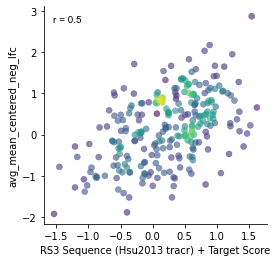

In [ ]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(gecko_activity_scores, y='avg_mean_centered_neg_lfc',
                         x='RS3 Sequence (Hsu2013 tracr) + Target Score')
gpplot.add_correlation(gecko_activity_scores, y='avg_mean_centered_neg_lfc',
                       x='RS3 Sequence (Hsu2013 tracr) + Target Score')
sns.despine()